## Домашнее задание №7

##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), @neychev

In [1]:
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F

import torchvision
from torchvision.datasets import MNIST

from matplotlib import pyplot as plt
from IPython.display import clear_output

%matplotlib inline

In [2]:
from sklearn.metrics import accuracy_score

### Задача №1:
Обратимся к классической задаче распознавания рукописных цифр. Мы будем работать с набором данных [MNIST](http://yann.lecun.com/exdb/mnist/). В данном задании воспользуемся всем датасетом целиком.

__Ваша основная задача: реализовать весь пайплан обучения модели и добиться качества $\geq 92\%$ на тестовой выборке.__

Код для обучения модели в данном задании отсутствует. Присутствует лишь несколько тестов, которые помогут вам отладить свое решение. За примером можно обратиться к ноутбуку первого занятия.

Настоятельно рекомендуем написать код "с нуля", лишь поглядывая на готовые примеры, а не просто "скопировать-вставить". Это поможет вам в дальнейшем.

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9.91M/9.91M [00:12<00:00, 807kB/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 223kB/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.65M/1.65M [00:01<00:00, 1.58MB/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 12.3MB/s]


torch.Size([1, 28, 28])


Text(0.5, 1.0, 'Image label: 2')

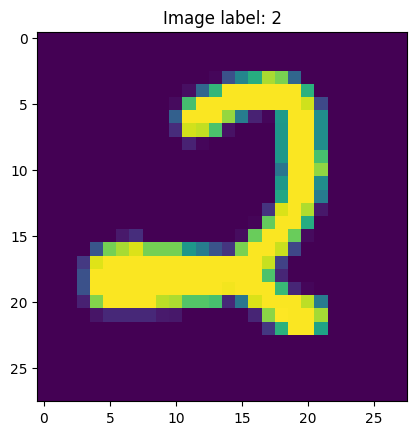

In [3]:
# do not change the code in the block below
# __________start of block__________

train_mnist_data = MNIST('.', train=True, transform=torchvision.transforms.ToTensor(), download=True)
test_mnist_data = MNIST('.', train=False, transform=torchvision.transforms.ToTensor(), download=True)


train_data_loader = torch.utils.data.DataLoader(
    train_mnist_data,
    batch_size=32,
    shuffle=True,
    num_workers=2
)

test_data_loader = torch.utils.data.DataLoader(
    test_mnist_data,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

random_batch = next(iter(train_data_loader))
_image, _label = random_batch[0][0], random_batch[1][0]
print(_image.shape)
plt.figure()
plt.imshow(_image.reshape(28, 28))
plt.title(f'Image label: {_label}')
# __________end of block__________

Постройте модель ниже. Пожалуйста, не стройте переусложненную сеть, не стоит делать ее глубже четырех слоев (можно и меньше). Ваша основная задача – обучить модель и получить качество на отложенной (тестовой выборке) не менее 92% accuracy.

*Комментарий: для этого достаточно линейных слоев и функций активации.*

__Внимание, ваша модель должна быть представлена именно переменной `model`.__

In [4]:
class DigitClassifier(nn.Module):
  def __init__(self, input_size, output_size, hidden_size=512):
    super().__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.relu1 = nn.ReLU()
    self.dropout = nn.Dropout(0.2)
    self.fc2 =  nn.Linear(hidden_size, output_size)
    self.softmax = nn.Softmax(1)

  def forward(self, data):
    data = self.relu1(self.fc1(data))
    data = self.dropout(data)
    data = self.fc2(data)
    return self.softmax(data)

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
# Creating model instance
model = DigitClassifier(784, 10) # your code here

model.to(device)

loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=5e-4)

Локальные тесты для проверки вашей модели доступны ниже:

In [7]:
# do not change the code in the block below
# __________start of block__________
assert model is not None, 'Please, use `model` variable to store your model'

try:
    x = random_batch[0].reshape(-1, 784)
    y = random_batch[1]

    # compute outputs given inputs, both are variables
    y_predicted = model(x.to(device))
except Exception as e:
    print('Something is wrong with the model')
    raise e


assert y_predicted.shape[-1] == 10, 'Model should predict 10 logits/probas'

print('Everything seems fine!')
# __________end of block__________

Everything seems fine!


Настройте параметры модели на обучающей выборке. Рекомендуем поработать с различными оптимизаторами.

In [8]:
def plot_train_process(
    train_loss, val_loss, train_accuracy, val_accuracy, title_suffix=""
):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title(" ".join(["Loss", title_suffix]))
    axes[0].plot(train_loss, label="train")
    axes[0].plot(val_loss, label="validation")
    axes[0].legend()

    axes[1].set_title(" ".join(["Validation accuracy", title_suffix]))
    axes[1].plot(train_accuracy, label="train")
    axes[1].plot(val_accuracy, label="validation")
    axes[1].legend()
    plt.show()

In [9]:
def train_model(model, train_loader, test_loader, loss_fn, optim,
                num_epochs=1000, eval_every=10, show_plot=True):
  train_loss_history = []
  train_acc_history = []
  test_loss_history = []
  test_acc_history = []

  local_train_loss_history = []
  local_train_acc_history = []

  epoch = 0
  for batch in train_loader:
    model.train()

    X_batch = batch[0].reshape(-1, 784).to(device)
    y_batch = batch[1].to(device)

    outs = model(X_batch)

    preds = torch.argmax(outs, dim=1)
    loss = loss_fn(outs, y_batch)

    loss.backward()

    optim.step()

    optim.zero_grad()

    local_train_acc_history.append(
        accuracy_score(
            y_batch.to('cpu').detach().numpy(),
            preds.to('cpu').detach().numpy()
        )
    )
    local_train_loss_history.append(loss.item())
    epoch += 1

    if epoch % eval_every == 0:
      train_loss_history.append(np.mean(local_train_loss_history))
      train_acc_history.append(np.mean(local_train_acc_history))
      local_train_loss_history, local_train_acc_history = [], []

      model.eval()
      with torch.no_grad():

        test_batch = next(iter(test_loader))

        X_test = test_batch[0].reshape(-1, 784).to(device)
        y_test = test_batch[1].to(device)

        outs_test = model(X_test)

        preds_test = torch.argmax(outs_test, dim=1)
        test_loss_history.append(loss_fn(outs_test, y_test).item())

        test_acc_score = accuracy_score(
            y_test.to('cpu').detach().numpy(),
            preds_test.to('cpu').detach().numpy()
        )
        test_acc_history.append(test_acc_score)

      if show_plot:
        clear_output(wait=True)
        plot_train_process(
            train_loss_history, test_loss_history, train_acc_history, test_acc_history
        )

    if epoch == num_epochs - 1: break

  return model

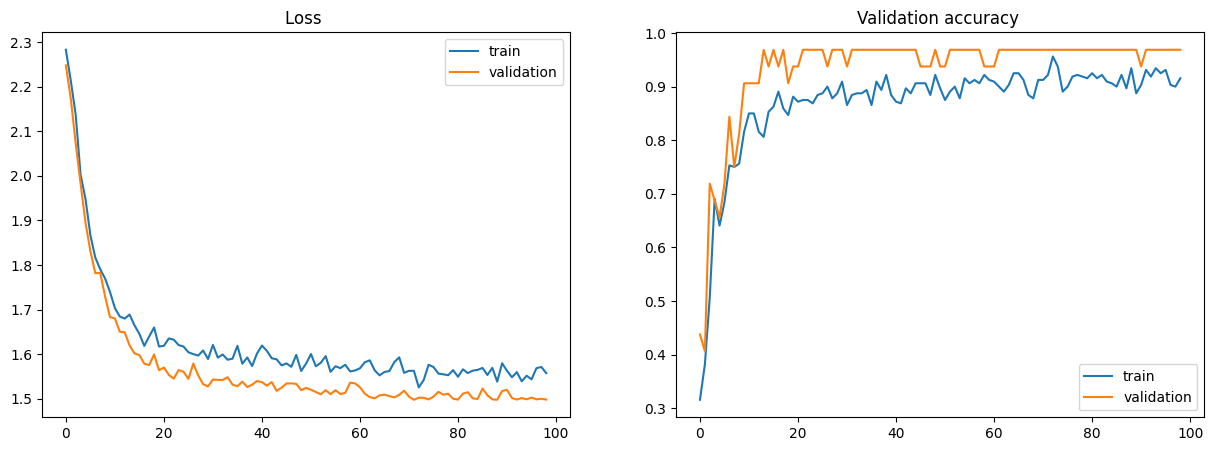

In [10]:
model = train_model(model, train_data_loader, test_data_loader, loss_fn,
                    opt)

Также, напоминаем, что в любой момент можно обратиться к замечательной [документации](https://pytorch.org/docs/stable/index.html) и [обучающим примерам](https://pytorch.org/tutorials/).  

Оценим качество классификации:

In [11]:
predicted_labels = []
real_labels = []
model.eval()
with torch.no_grad():
    for batch in train_data_loader:
        y_predicted = model(batch[0].reshape(-1, 784).to(device))
        predicted_labels.append(y_predicted.argmax(dim=1))
        real_labels.append(batch[1])

predicted_labels = torch.cat(predicted_labels)
real_labels = torch.cat(real_labels)
train_acc = (predicted_labels.to('cpu') == real_labels).type(torch.FloatTensor).mean()

In [12]:
print(f'Neural network accuracy on train set: {train_acc:3.5}')

Neural network accuracy on train set: 0.9236


In [13]:
predicted_labels = []
real_labels = []
model.eval()
with torch.no_grad():
    for batch in test_data_loader:
        y_predicted = model(batch[0].reshape(-1, 784).to(device))
        predicted_labels.append(y_predicted.argmax(dim=1))
        real_labels.append(batch[1])

predicted_labels = torch.cat(predicted_labels)
real_labels = torch.cat(real_labels)
test_acc = (predicted_labels.to('cpu') == real_labels).type(torch.FloatTensor).mean()

In [14]:
print(f'Neural network accuracy on test set: {test_acc:3.5}')

Neural network accuracy on test set: 0.9268


Проверка, что необходимые пороги пройдены:

In [15]:
assert test_acc >= 0.92, 'Test accuracy is below 0.92 threshold'
assert train_acc >= 0.91, 'Train accuracy is below 0.91 while test accuracy is fine. We recommend to check your model and data flow'

### Сдача задания
Загрузите файл `hw07_data_dict.npy` (ссылка есть на странице с заданием) и запустите код ниже для генерации посылки. Код ниже может его загрузить (но в случае возникновения ошибки скачайте и загрузите его вручную).

In [16]:
!wget https://raw.githubusercontent.com/girafe-ai/ml-course/23s_dd_ml/homeworks/hw07_mnist_classification/hw07_data_dict.npy

--2025-03-11 19:15:14--  https://raw.githubusercontent.com/girafe-ai/ml-course/23s_dd_ml/homeworks/hw07_mnist_classification/hw07_data_dict.npy
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8003::154, 2606:50c0:8001::154, 2606:50c0:8002::154, ...
connected. to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8003::154|:443... 
HTTP request sent, awaiting response... 200 OK
Length: 6272438 (6.0M) [application/octet-stream]
Saving to: ‘hw07_data_dict.npy.1’

hw07_data_dict.npy. 100%[===================>]   5.98M  1.53MB/s    in 4.9s    

2025-03-11 19:15:19 (1.21 MB/s) - ‘hw07_data_dict.npy.1’ saved [6272438/6272438]



In [17]:
# do not change the code in the block below
# __________start of block__________
import os

assert os.path.exists('hw07_data_dict.npy'), 'Please, download `hw07_data_dict.npy` and place it in the working directory'

def get_predictions(model, eval_data, step=10):

    predicted_labels = []
    model.eval()
    with torch.no_grad():
        for idx in range(0, len(eval_data), step):
            y_predicted = model(eval_data[idx:idx+step].reshape(-1, 784).to(device))
            predicted_labels.append(y_predicted.to('cpu').argmax(dim=1))

    predicted_labels = torch.cat(predicted_labels)
    return predicted_labels

loaded_data_dict = np.load('hw07_data_dict.npy', allow_pickle=True)

submission_dict = {
    'train': get_predictions(model, torch.FloatTensor(loaded_data_dict.item()['train'])).numpy(),
    'test': get_predictions(model, torch.FloatTensor(loaded_data_dict.item()['test'])).numpy()
}

np.save('submission_dict_hw07.npy', submission_dict, allow_pickle=True)
print('File saved to `submission_dict_hw07.npy`')
# __________end of block__________

File saved to `submission_dict_hw07.npy`


На этом задание завершено. Поздравляем!